In [320]:
import numpy as np
import pandas as pd

# Visualization
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt

# Ignore Warnings on Prophet
import warnings  
warnings.filterwarnings('ignore')

In [321]:
df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
df = df[df['Country/Region'] == 'Indonesia']
df = df.iloc[:, 4:]
df = df.T.reset_index()
df = df.rename(columns={'index': 'ds', 148: 'y'})
df = df[df['y'] > 0]
df['ds'] = pd.to_datetime(df['ds'], format = '%m/%d/%y')
df

,ds,y
40,2020-03-02,2
41,2020-03-03,2
42,2020-03-04,2
43,2020-03-05,2
44,2020-03-06,4
...,...,...
617,2021-09-30,4215104
618,2021-10-01,4216728
619,2021-10-02,4218142
620,2021-10-03,4219284


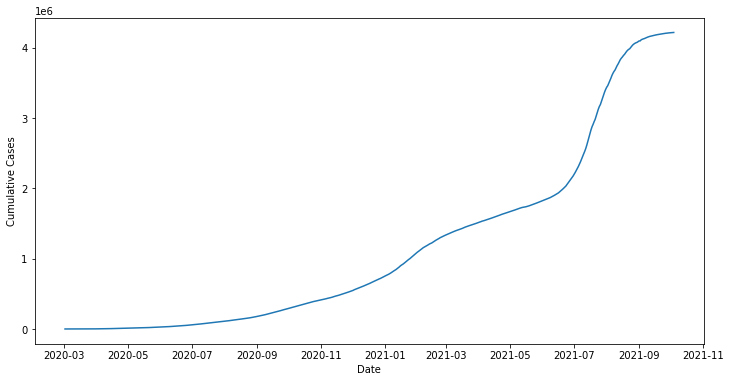

In [322]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x="ds", y="y")
plt.xlabel('Date')
plt.ylabel('Cumulative Cases')
plt.show()

In [323]:
from sklearn.model_selection import train_test_split

X = df["ds"]
y = df["y"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=42,shuffle=False)

train_data = {'ds': X_train, 'y': y_train}
train_data = pd.DataFrame(train_data)
train_data['ds'] = pd.to_datetime(train_data['ds'])
train_data['cap'] = 4500000
print(train_data.shape)

test_data = {'ds': X_test, 'y': y_test}
test_data = pd.DataFrame(test_data)
test_data['ds'] = pd.to_datetime(test_data['ds'])
test_data['cap'] = 4500000
print(test_data.shape)

(552, 3)
(30, 3)


In [324]:
train_data.tail()

,ds,y,cap
587,2021-08-31,4089801,4500000
588,2021-09-01,4100138,4500000
589,2021-09-02,4100138,4500000
590,2021-09-03,4116890,4500000
591,2021-09-04,4123617,4500000


In [325]:
from fbprophet import Prophet

m = Prophet(growth='logistic',interval_width=0.95, 
            changepoint_prior_scale=0.5,
            seasonality_prior_scale = 20,
             holidays_prior_scale = 25,
            seasonality_mode = 'additive',
            changepoint_range=0.95, daily_seasonality=True,
            weekly_seasonality=False)
m.add_country_holidays(country_name='ID')
m.fit(train_data)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [326]:
future = m.make_future_dataframe(periods=30)
future['cap'] = 4500000

In [327]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
577,2021-09-30,4.351140e+06,4.323253e+06,4.375952e+06
578,2021-10-01,4.355701e+06,4.326866e+06,4.382654e+06
579,2021-10-02,4.360101e+06,4.333633e+06,4.385126e+06
580,2021-10-03,4.364344e+06,4.335009e+06,4.389639e+06
581,2021-10-04,4.368435e+06,4.339742e+06,4.395000e+06


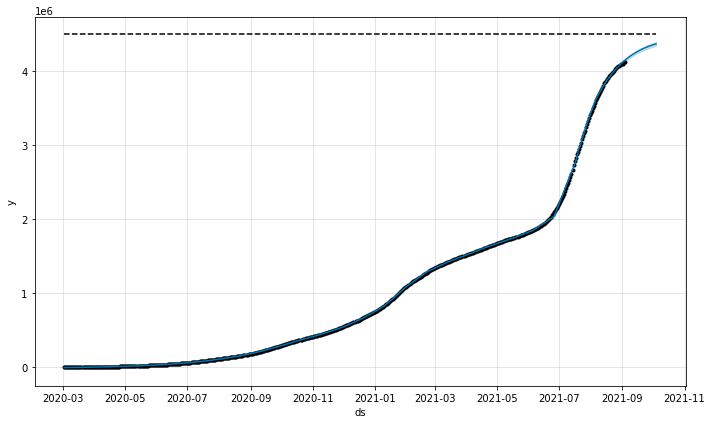

In [328]:
confirmed_forecast_plot = m.plot(forecast)

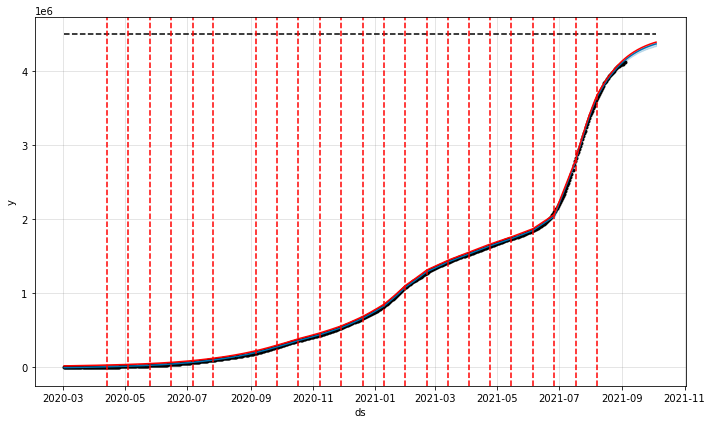

In [329]:
from fbprophet.plot import add_changepoints_to_plot
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

In [330]:
forecast_after = forecast[forecast["ds"] > "2021-09-04"] 

In [331]:
fig = go.Figure(data=[
    go.Bar(name='Total Cases', x=train_data['ds'], y=train_data['y']),
    go.Bar(name='Total Cases Forecasted', x=forecast_after['ds'], y=forecast_after['yhat'])
])

fig.update_layout(barmode='group', title='Indonesian Cases + Forecasted Cases')
fig.show()

In [332]:
fig = go.Figure(data=[
    go.Bar(name='Total Cases', x=train_data['ds'], y=train_data['y']),
    go.Bar(name='Future Cases', x=test_data['ds'], y=test_data['y'])
])

fig.update_layout(barmode='group', title='Indonesian Cases + Future Cases')
fig.show()

In [333]:
from sklearn.metrics import max_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

print("Max Error: " + str(max_error(test_data["y"], forecast_after["yhat"])))
print("Mean Absolute Error: " + str(mean_absolute_error(test_data["y"], forecast_after["yhat"])))
print("R2 Score: " + str(r2_score(test_data["y"], forecast_after["yhat"])))
print("Root Mean Square Error: " + str(mean_squared_error(test_data["y"], forecast_after["yhat"], squared=False)))

Max Error: 148229.2758474322
Mean Absolute Error: 96598.54547752655
R2 Score: -13.596711513212762
Root Mean Square Error: 102342.65733683942


# Testing

In [336]:
from fbprophet import Prophet

m2 = Prophet(growth='linear',interval_width=0.95, 
            changepoint_prior_scale=0.5,
            seasonality_prior_scale = 20,
             holidays_prior_scale = 25,
            seasonality_mode = 'additive',
            changepoint_range=0.95, daily_seasonality=True,
            weekly_seasonality=False)
m2.add_country_holidays(country_name='ID')
m2.fit(df)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [337]:
future2 = m2.make_future_dataframe(periods=30)

In [344]:
forecast2 = m2.predict(future2)
forecast2[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(30)

,ds,yhat,yhat_lower,yhat_upper
582,2021-10-05,4.231600e+06,4.211826e+06,4.250156e+06
583,2021-10-06,4.234461e+06,4.215518e+06,4.252451e+06
584,2021-10-07,4.237322e+06,4.216598e+06,4.256686e+06
585,2021-10-08,4.240183e+06,4.220946e+06,4.260080e+06
586,2021-10-09,4.243044e+06,4.220528e+06,4.264531e+06
587,2021-10-10,4.245905e+06,4.222092e+06,4.268126e+06
588,2021-10-11,4.248766e+06,4.223685e+06,4.273100e+06
589,2021-10-12,4.251627e+06,4.221994e+06,4.283237e+06
590,2021-10-13,4.254488e+06,4.216607e+06,4.292924e+06
591,2021-10-14,4.257349e+06,4.215321e+06,4.305724e+06
